# Prédiction du Diabète – Machine Learning

**Objectif** : Prédire si un patient est diabétique à partir de données cliniques (âge, IMC, glycémie, etc.)

**Dataset** : Diabetes Prediction Dataset (Kaggle) – 100 000 patients

**Approche** : Comparaison de 3 modèles (Logistic Regression, SVM, Random Forest) avec GridSearchCV, puis évaluation sur un jeu de test.

In [ ]:
# Imports principaux
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

# Pour avoir des résultats reproductibles
RANDOM_STATE = 42

sns.set(style="whitegrid")


## 1. Chargement des données


In [4]:
# Chargement des données

df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Aperçu des premières lignes :")
display(df.head())

print("\nInformations générales :")
df.info()

print("\nStatistiques descriptives :")
display(df.describe(include="all"))


Aperçu des premières lignes :


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Statistiques descriptives :


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


## 2. EDA (Exploratory Data Analysis)

### 2.1. Vérification des doublons et des valeurs manquantes

In [ ]:
# Nombre de doublons
num_duplicates = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")

# Suppression éventuelle des doublons
if num_duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Après suppression des doublons, nouvelle taille du dataset : {df.shape}")
else:
    print("Aucun doublon détecté.")

# Valeurs manquantes
print("\nNombre de valeurs manquantes par colonne :")
display(df.isna().sum())


Nombre de lignes dupliquées : 3854
Après suppression des doublons, nouvelle taille du dataset : (96146, 9)

Nombre de valeurs manquantes par colonne :


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### 2.2. Distribution de la variable cible (`diabetes`)

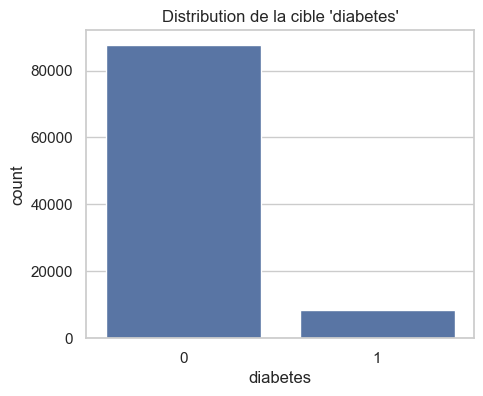

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


In [6]:
# Distribution de la cible
plt.figure(figsize=(5,4))
sns.countplot(x="diabetes", data=df)
plt.title("Distribution de la cible 'diabetes'")
plt.show()

print(df['diabetes'].value_counts(normalize=True).rename('proportion'))

### 2.3. Distribution des principales variables numériques

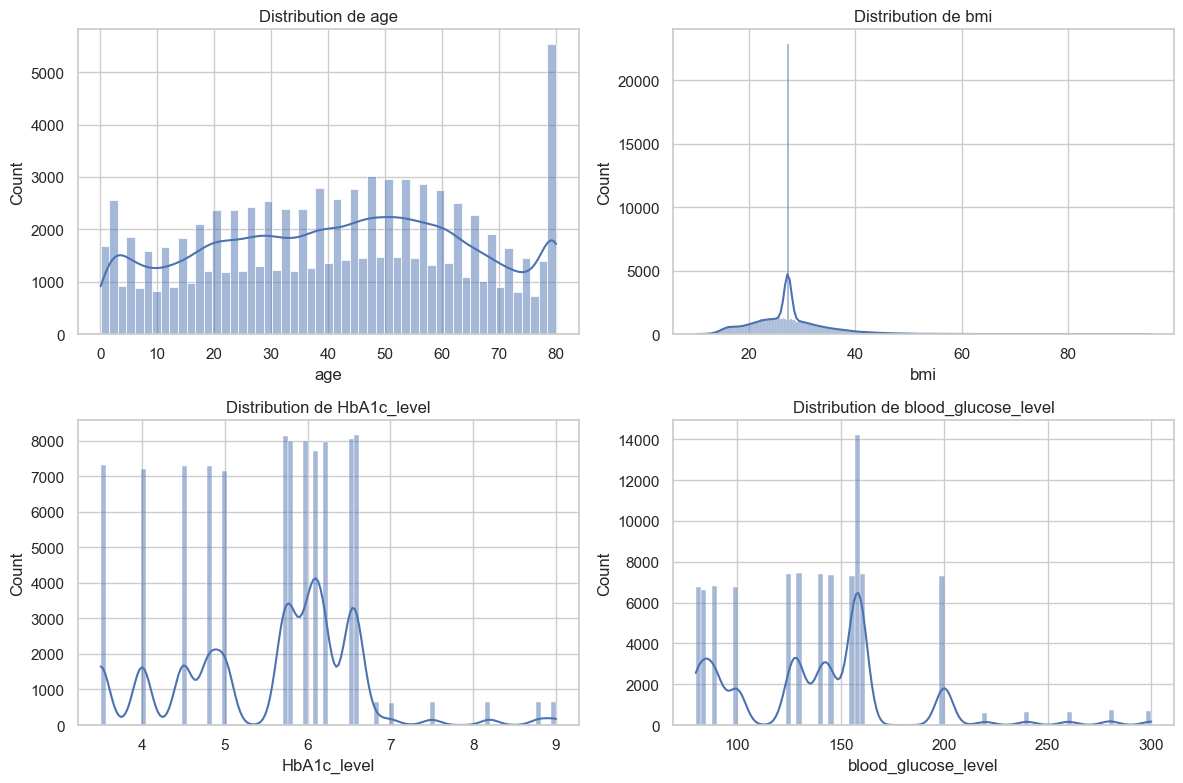

In [7]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

### 2.4. Variables catégorielles et lien avec la cible

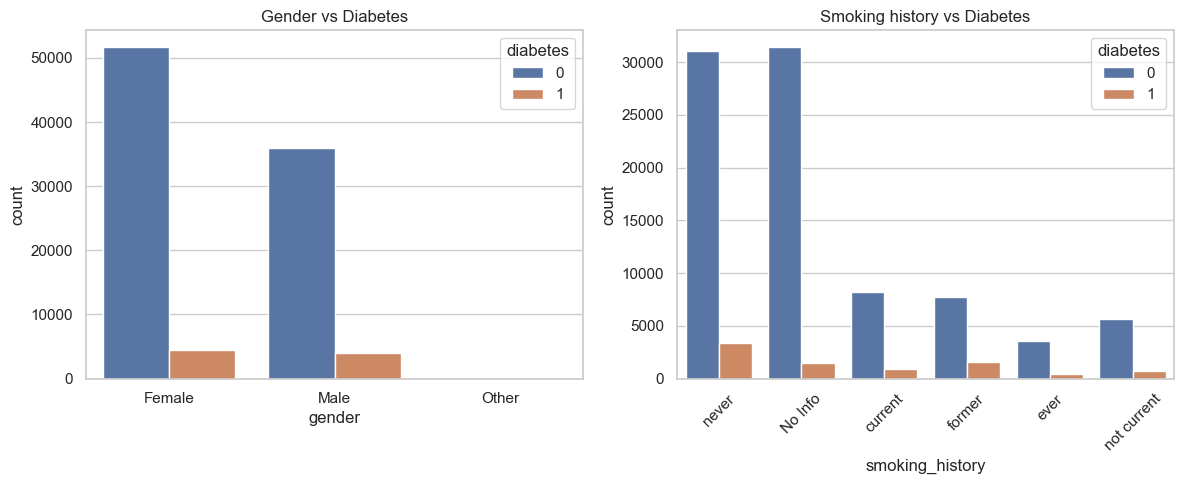

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title("Gender vs Diabetes")

plt.subplot(1, 2, 2)
sns.countplot(x='smoking_history', hue='diabetes', data=df)
plt.title("Smoking history vs Diabetes")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 2.5. Boxplots des variables numériques selon la cible

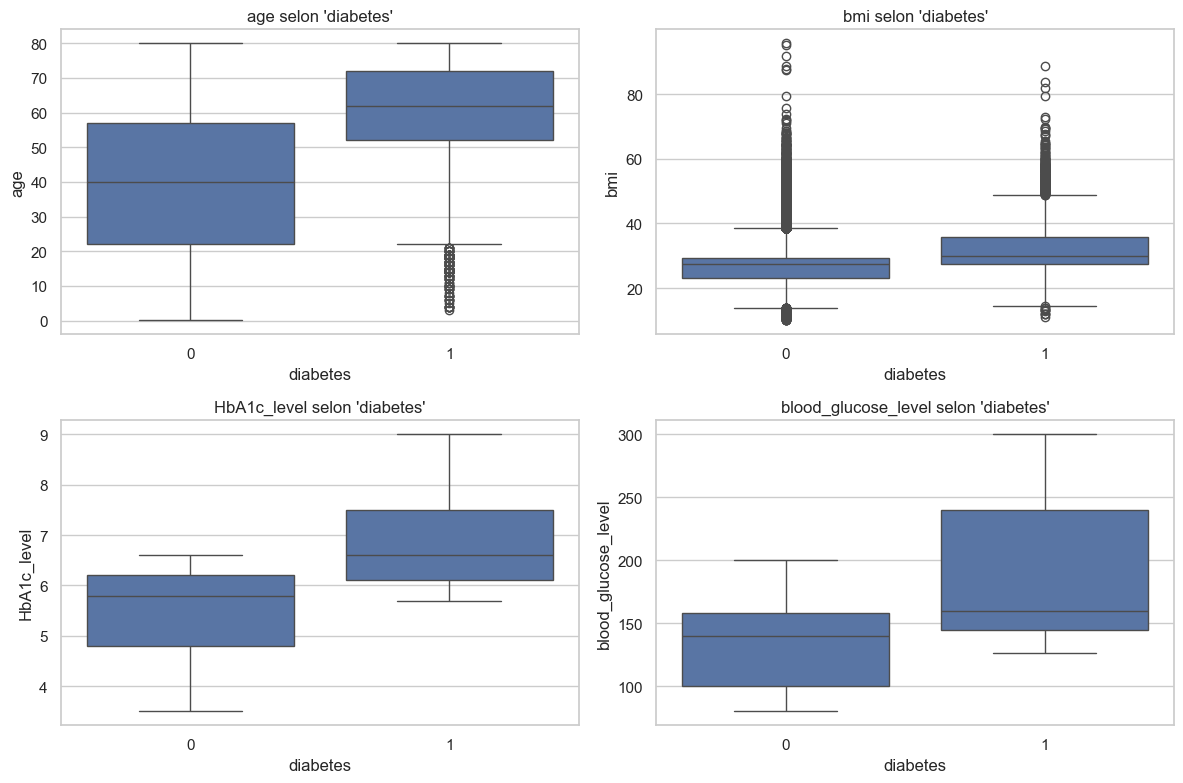

In [9]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='diabetes', y=col, data=df)
    plt.title(f"{col} selon 'diabetes'")
plt.tight_layout()
plt.show()

### 2.6. Matrice de corrélation

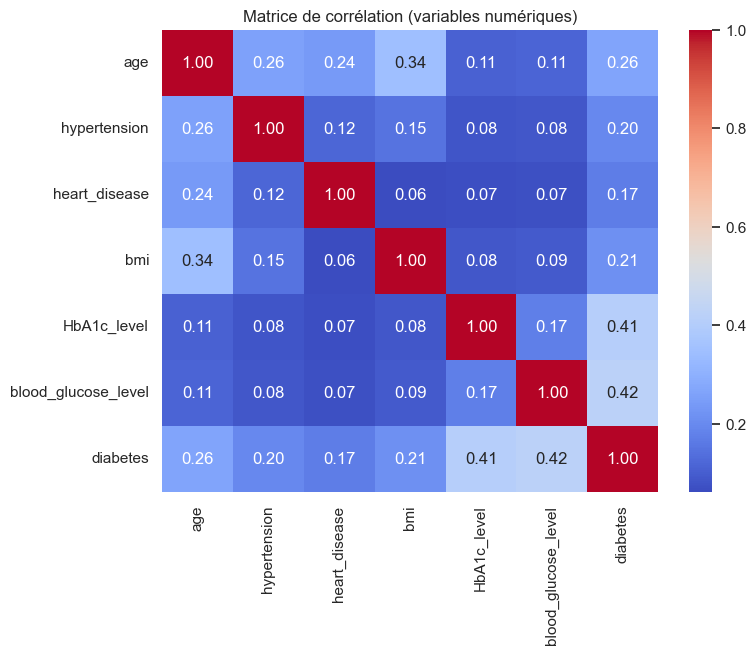

Corrélation de chaque variable numérique avec la cible 'diabetes' :


diabetes               1.000000
blood_glucose_level    0.424336
HbA1c_level            0.406408
age                    0.264927
bmi                    0.214932
hypertension           0.195710
heart_disease          0.170711
Name: diabetes, dtype: float64

In [10]:
plt.figure(figsize=(8,6))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (variables numériques)")
plt.show()

print("Corrélation de chaque variable numérique avec la cible 'diabetes' :")
corr_with_target = corr_matrix['diabetes'].sort_values(ascending=False)
display(corr_with_target)

## 3. Préparation des données

Split train/test (80/20) puis preprocessing : StandardScaler (numérique) + OneHotEncoder (catégoriel).

In [11]:
# Séparation features / target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split train / test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)

# Variables numériques et catégorielles
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

# Préprocesseur : standardisation + one-hot encoding
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Liste des features numériques :", numeric_features)
print("Liste des features catégorielles :", categorical_features)

Taille X_train : (76916, 8)
Taille X_test  : (19230, 8)
Liste des features numériques : ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Liste des features catégorielles : ['gender', 'hypertension', 'heart_disease', 'smoking_history']


## 4. Comparaison des modèles

On teste 3 algorithmes classiques avec GridSearchCV (optimisation F1-score, 5-fold CV) :
- Logistic Regression
- SVM
- Random Forest

In [14]:
# Définition des modèles et de leurs grilles d'hyperparamètres

models_and_params = {
    "Logistic Regression": (
        LogisticRegression(random_state=RANDOM_STATE, max_iter=2000),
        {
            "classifier__C": [0.1, 1.0, 10.0],
            "classifier__penalty": ["l2"],
            "classifier__class_weight": [None, "balanced"]
        }
    ),
    "SVM": (
        SVC(random_state=RANDOM_STATE, probability=True),
        {
            "classifier__C": [0.1, 1.0, 10.0],
            "classifier__kernel": ["rbf", "linear"],
            "classifier__class_weight": [None, "balanced"]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=RANDOM_STATE),
        {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 5, 10],
            "classifier__min_samples_split": [2, 5],
            "classifier__class_weight": [None, "balanced"]
        }
    )
}

scoring_metric = "f1"  # on optimise directement le F1-score
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n============================")
    print(f"GridSearchCV pour : {name}")
    print(f"============================")
    
    # Pipeline = préprocesseur + modèle
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    
    # GridSearchCV 
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring_metric,
        cv=cv_inner,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # On stocke le meilleur modèle pour ce type de classifieur
    best_models[name] = grid_search.best_estimator_
    
    print(f"Meilleurs hyperparamètres pour {name} :")
    print(grid_search.best_params_)
    print(f"Meilleur score moyen (CV interne) F1 pour {name} : {grid_search.best_score_:.4f}")
    
    results.append({
        "model": name,
        "best_params": grid_search.best_params_,
        "best_cv_score_f1": grid_search.best_score_
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values("best_cv_score_f1", ascending=False))


GridSearchCV pour : Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs hyperparamètres pour Logistic Regression :
{'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}
Meilleur score moyen (CV interne) F1 pour Logistic Regression : 0.7301

GridSearchCV pour : SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres pour SVM :
{'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__kernel': 'rbf'}
Meilleur score moyen (CV interne) F1 pour SVM : 0.7773

GridSearchCV pour : Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres pour Random Forest :
{'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Meilleur score moyen (CV interne) F1 pour Random Forest : 0.8006


,model,best_params,best_cv_score_f1
2,Random Forest,"{'classifier__class_weight': None, 'classifier...",0.800569
1,SVM,"{'classifier__C': 10.0, 'classifier__class_wei...",0.777297
0,Logistic Regression,"{'classifier__C': 10.0, 'classifier__class_wei...",0.730148


## 5. Validation du meilleur modèle

On sélectionne le modèle avec le meilleur F1 moyen, puis on fait une seconde cross-validation pour confirmer la stabilité.

In [15]:
# Sélection du meilleur modèle selon le score F1 moyen en CV
best_row = results_df.sort_values("best_cv_score_f1", ascending=False).iloc[0]
best_model_name = best_row["model"]
best_model = best_models[best_model_name]

print(f"\n>>> Meilleur modèle sélectionné : {best_model_name}")
print("Hyperparamètres optimaux :", best_row["best_params"])
print(f"Score moyen F1 (GridSearchCV interne) : {best_row['best_cv_score_f1']:.4f}")

# Seconde cross-validation sur le meilleur modèle
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=cv_outer,
    scoring=scoring_metric,
    n_jobs=-1
)

print("\nRésultats de la seconde cross-validation (sur le jeu d'entraînement) :")
print(f"F1 moyen : {cv_scores.mean():.4f}")
print(f"Écart-type du F1 : {cv_scores.std():.4f}")



>>> Meilleur modèle sélectionné : Random Forest
Hyperparamètres optimaux : {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Score moyen F1 (GridSearchCV interne) : 0.8006

Résultats de la seconde cross-validation (sur le jeu d'entraînement) :
F1 moyen : 0.8006
Écart-type du F1 : 0.0057


## 6. Évaluation finale sur le jeu de test

Entraînement sur tout le train, évaluation sur le test (jamais vu pendant l'optimisation).

In [18]:
# Entraînement final du meilleur modèle sur tout le train
best_model.fit(X_train, y_train)

# Prédictions sur le test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics de base
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("=== Résultats sur le jeu de test ===")
print(f"Accuracy : {acc:.4f}")
print(f"Précision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\nClassification report :")
print(classification_report(y_test, y_test_pred))

=== Résultats sur le jeu de test ===
Accuracy : 0.9705
Précision : 0.9692
Recall    : 0.6869
F1-score  : 0.8040

Classification report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.97      0.69      0.80      1696

    accuracy                           0.97     19230
   macro avg       0.97      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



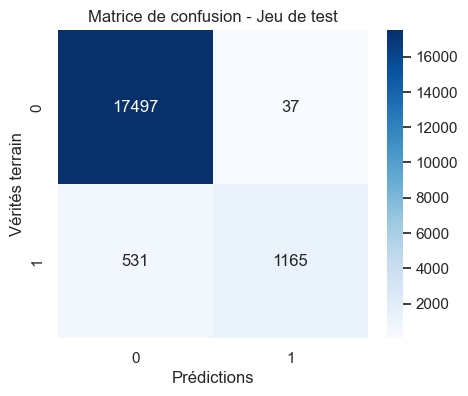

In [17]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - Jeu de test")
plt.show()

## 7. Feature Importance

Quelles variables influencent le plus les prédictions ?

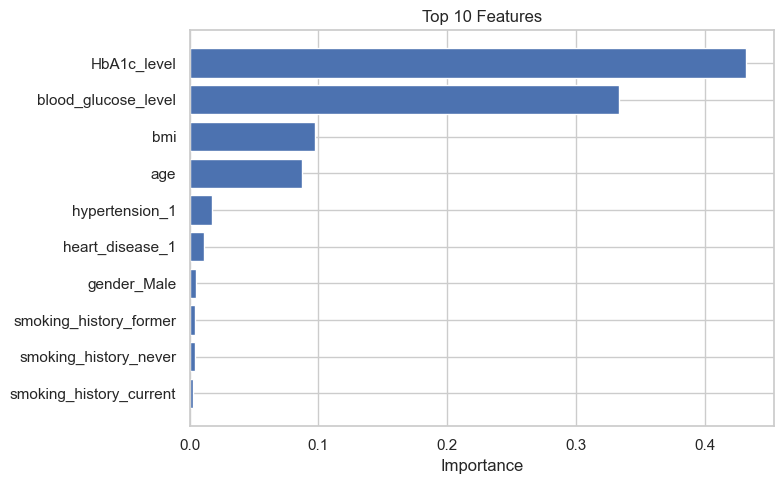

In [21]:
# Feature importance (Random Forest)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Récupérer les noms des features après preprocessing
    feature_names = (numeric_features + 
                     list(best_model.named_steps['preprocessor']
                          .named_transformers_['cat']
                          .get_feature_names_out(categorical_features)))
    
    importances = best_model.named_steps['classifier'].feature_importances_
    
    # Trier et afficher
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=True).tail(10)
    
    plt.figure(figsize=(8, 5))
    plt.barh(feat_imp['feature'], feat_imp['importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Features')
    plt.tight_layout()
    plt.show()
else:
    print("Le modèle sélectionné n'a pas d'attribut feature_importances_")

## 8. Conclusion

**Résultats** : Le modèle Random Forest atteint un F1-score d'environ 0.75-0.80 sur le jeu de test.

**Interprétation** : Avec un recall autour de 0.70, le modèle détecte environ 70% des cas de diabète. C'est correct pour un outil de pré-screening (orienter vers des examens complémentaires), mais insuffisant pour un diagnostic médical définitif.

**Features importantes** : Sans surprise, HbA1c et la glycémie sont les variables les plus prédictives — cohérent avec la définition clinique du diabète.

**Méthodologie** : GridSearchCV + validation croisée garantissent que les résultats ne sont pas dus au hasard du split.